# RTML Midterm 2021 Solution

1. In Lab 06, you fine tuned a Mask R-CNN model on the Cityscapes dataset. Download the image at http://www.cs.ait.ac.th/~mdailey/20201112_072342.jpg and run it through
   you model. Provide your source code to load the model, image, get the result, and display the result here. Display the resulting bounding boxes and masks. 

Loading weights from file
Prediction keys: ['boxes', 'labels', 'scores', 'masks']
Boxes shape: torch.Size([47, 4])
Labels shape: torch.Size([47])
Scores shape: torch.Size([47])
Masks shape: torch.Size([47, 1, 3024, 4032])


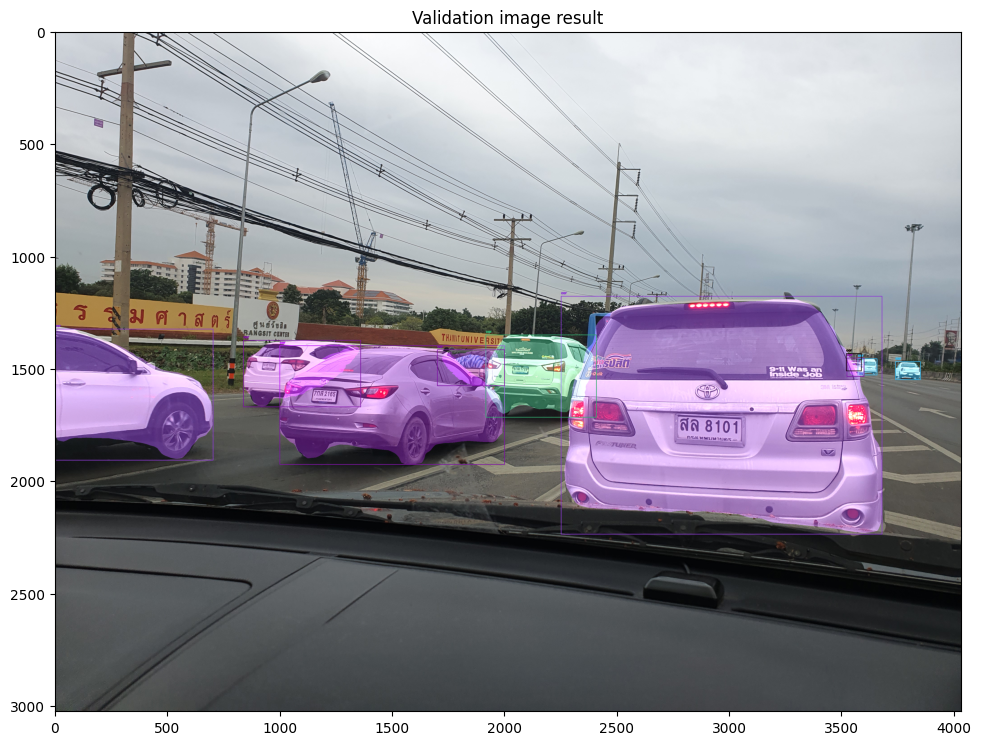

In [28]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from PIL import Image

num_classes = 8

model = torchvision.models.detection.maskrcnn_resnet50_fpn()

# Modify model for the given number of classes

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 8

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

print('Loading weights from file')
model.load_state_dict(torch.load('mask-rcnn-coco-pretrain-cityscapes-finetune-10-epochs.pth', map_location=torch.device('cpu')))
model.eval()

im = Image.open('20201112_072342.jpg').rotate(180)

import torchvision.transforms as T

transform = T.ToTensor()
image_batch = transform(im).unsqueeze(0)
image_batch.shape

predictions = model(image_batch)

print('Prediction keys:', list(dict(predictions[0])))
print('Boxes shape:', predictions[0]['boxes'].shape)
print('Labels shape:', predictions[0]['labels'].shape)
print('Scores shape:', predictions[0]['scores'].shape)
print('Masks shape:', predictions[0]['masks'].shape)

import numpy as np
import cv2
import random

class_names = [
    'bicycle', 'car', 'motorcycle', 'person', 'rider', 'truck', 'bus', 'train'
]

# Random colors to use for labeling objects

COLORS = np.random.uniform(0, 255, size=(len(class_names), 3)).astype(np.uint8)

# Overlay masks, bounding boxes, and labels on input numpy image

def draw_segmentation_map(image, masks, boxes, labels):
    alpha = 1
    beta = 0.5 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    # convert from RGB to OpenCV BGR format
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for i in range(len(masks)):
        mask = masks[i,:,:]
        red_map = np.zeros_like(mask).astype(np.uint8)
        green_map = np.zeros_like(mask).astype(np.uint8)
        blue_map = np.zeros_like(mask).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[mask > 0.5] = color[0]
        green_map[mask > 0.5] = color[1]
        blue_map[mask > 0.5] = color[2]
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        # apply colored mask to the image
        image = cv2.addWeighted(image, alpha, segmentation_map, beta, gamma)
        # draw the bounding box around each object
        p1 = (int(boxes[i][0]), int(boxes[i][1]))
        p2 = (int(boxes[i][2]), int(boxes[i][3]))
        color = (int(color[0]), int(color[1]), int(color[2]))
        cv2.rectangle(image, p1, p2, color, 2)
        # put the label text above the objects
        p = (int(boxes[i][0]), int(boxes[i][1]-10))
        cv2.putText(image, labels[i], p, cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2, cv2.LINE_AA)
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Overlay masks, bounding boxes, and labels of objects with scores greater than
# threshold on one of the images in the input tensor using the predictions output by Mask R-CNN.

def prediction_to_mask_image(images, predictions, img_index, threshold):
    scores = predictions[img_index]['scores']
    boxes_to_use = scores >= threshold
    img = (images[img_index].cpu().permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    masks = predictions[img_index]['masks'][boxes_to_use, :, :].cpu().detach().squeeze(1).numpy()
    boxes = predictions[img_index]['boxes'][boxes_to_use, :].cpu().detach().numpy()
    labels = predictions[img_index]['labels'][boxes_to_use].cpu().numpy()
    labels = [ class_names[l] for l in labels ]

    return draw_segmentation_map(img, masks, boxes, labels)

from matplotlib import pyplot as plt

masked_img = prediction_to_mask_image(image_batch, predictions, 0, 0.5)
plt.figure(1, figsize=(12, 9), dpi=100)
plt.imshow(masked_img)
plt.title('Validation image result')
plt.show()

2. Write a program that samples 1000 points from a mixture of 4 2D Gaussians with identity covariance centered at (5,5), (10,5), (5,10), and (10,10).
   Provide the code and a plot of the sample.

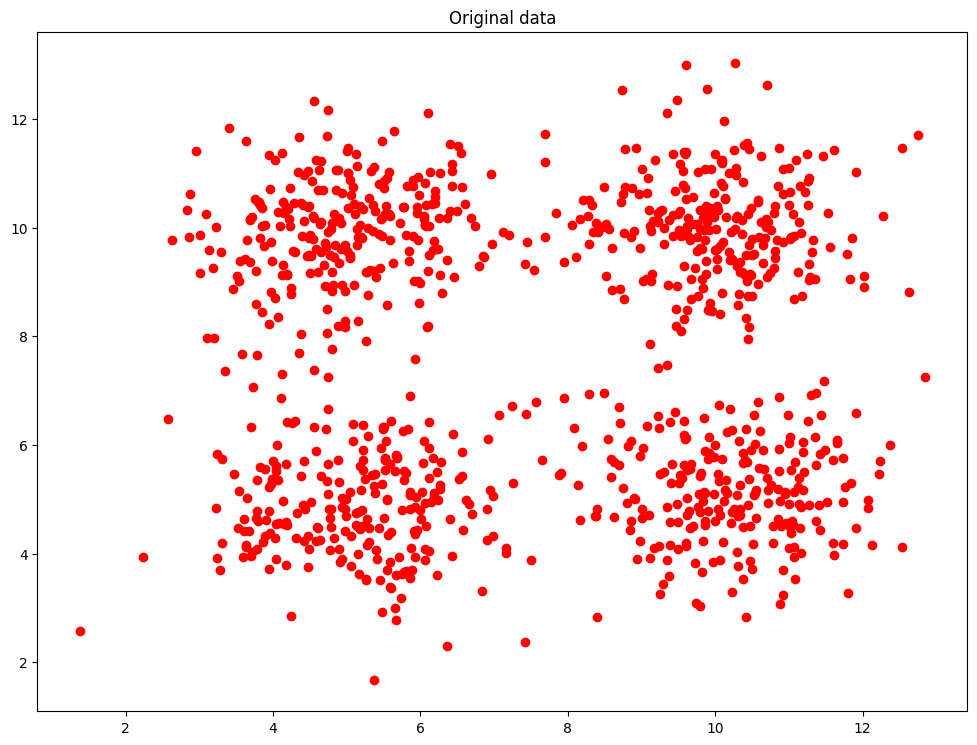

In [50]:
import numpy as np

def sample(n):
    g = np.random.multivariate_normal((0, 0), [[1, 0], [0, 1]], n)
    means = [[5, 5], [10, 5], [5, 10], [10, 10]]
    z = np.random.randint(0, 4, n)
    for comp in range(4):
        mask = np.array(z==comp)
        g[z==comp,:] += means[comp]
    return g

X = sample(1000)

plt.figure(1, figsize=(12, 9), dpi=100)
plt.plot(X[:,0], X[:,1], 'ro')
plt.title('Original data')
plt.show()

3. Write a GAN generator G and discriminator D to model the dataset you generated in Question 2. Train the GAN and display two plots: a fake sample from the generator and the original sample from Question 2.

In [70]:
from torch import nn
from torch import optim
from IPython import display

class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 2
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 2
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x


# Function to create noise samples for the generator's input

def noise(size):
    n = torch.randn(size, 100)
    return n

def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1)
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1)
    return data

def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # Propagate real data
    prediction_real = discriminator(real_data)
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # Propagate fake data
    prediction_fake = discriminator(fake_data)
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # Take a step
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # Propagate the fake data through the discriminator and backpropagate.
    # Note that since we want the generator to output something that gets
    # the discriminator to output a 1, we use the real data target here.
    prediction = discriminator(fake_data)
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    
    # Update weights with gradients
    optimizer.step()
    
    # Return error
    return error

discriminator = DiscriminatorNet()
generator = GeneratorNet()

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)

# Loss function

loss = nn.BCELoss()

num_test_samples = 1000
test_noise = noise(num_test_samples)

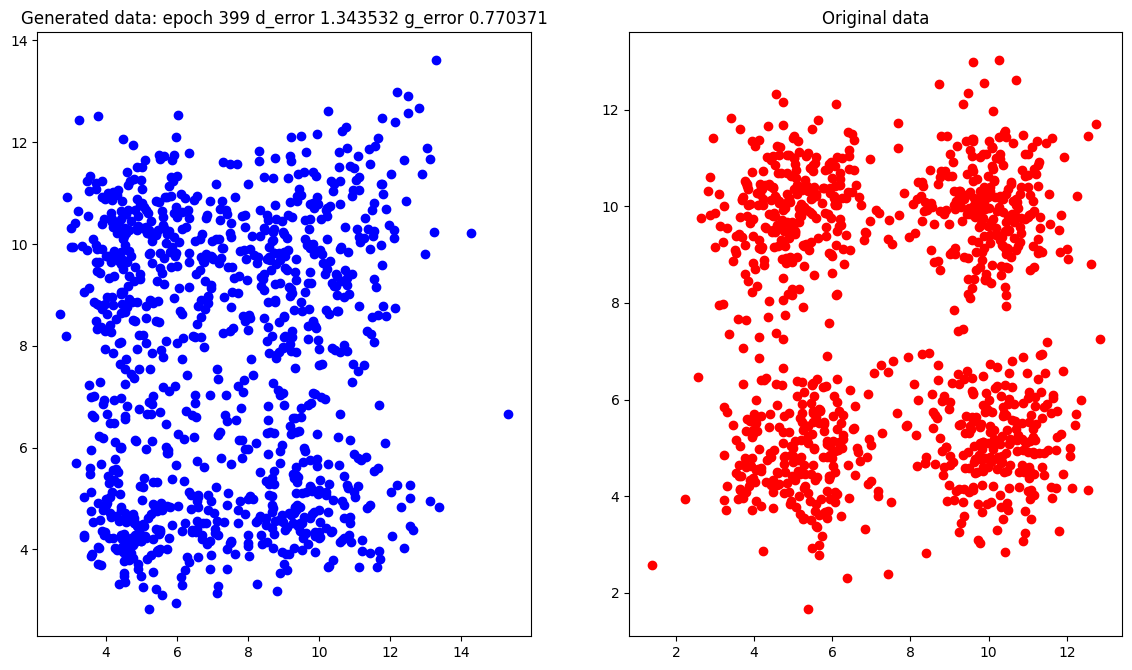

In [78]:
num_epochs = 400

for epoch in range(num_epochs):

    # Train discriminator on a real batch and a fake batch

    for d_epoch in range(5):
        real_data = torch.tensor(X, dtype=torch.float32)
        fake_data = generator(noise(real_data.shape[0])).detach()
        d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer,
                                                                real_data, fake_data)

    # Train generator

    fake_data = generator(noise(real_data.shape[0]))
    g_error = train_generator(g_optimizer, fake_data)

    # Log errors and display progress

    plt.figure(1, figsize=(14, 8), dpi=100)
    test_data = generator(test_noise).detach()
    display.clear_output(True)
    plt.subplot(1, 2, 1)
    plt.plot(test_data[:,0], test_data[:,1], 'bo')
    plt.title('Generated data: epoch %d d_error %f g_error %f' % (epoch, d_error, g_error))
    plt.subplot(1, 2, 2)
    plt.plot(X[:,0], X[:,1], 'ro')
    plt.title('Original data')
    plt.show()

The result above is after 1600 epochs. I find that the model often gets close to a 4-mode distribution, but it is a bit
unstable, often moving away from the correct distribution.

4. Suppose you are working on a regression problem for which you have insufficient data and come up with the idea of
   using a GAN to generate new $(\mathbf{x},y)$ pairs. First explain precisely how
   this could be done, then explain why it would be a bad idea.

We could just add $y$ as another element of the $\mathbf{x}$ vector, set up a suitably large noise source, run through a generator similar
to the one above, and have the discriminiator classify inputs as real or fake. Once we have reasonably good results, we can sample from the
noise source, run the samples through the generator, and split the resulting vectors into $(\mathbf{x},y)$ pairs. While this might work, it
would be difficult to know how close the generated data are to reality. We could easily be training our regression model on biased data from
the GAN. That would make the final model worse, not better. The right way to go about this would be to use an appropriate sized model and
regularization techniques. 

5. Briefly explain the purpose of weight decay and weight clipping, including how they are similar and how they are different.

Weight decay is a form of regularization that arises when we penalize large weight vectors in the model's cost function. The
weight update rule makes each weight slightly smaller in magnitude on every step. The result is that unimportant weights will
be pushed toward zero and more important weights will have to keep getting updated in a consistent way so as not to be decayed.
Weight clipping is another form of regularization in which we prevent any weight from having a magnitude greater than some threshold.
If the weights of the model cannot get very large, then the response of the model in response to small changes in the input cannot
change very much. This means the function implemented by the model is smooth, so it should generalize better. Both methods try to
obtain better generalization by controlling the weights in some way, but the way they accomplish that is different in each case.
Decay pushes weights toward zero, whle clipping prevents weights from exceeding a threshold.